In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from surprise import Dataset
# from surprise import Reader
# from surprise.model_selection import cross_validate
# from surprise.model_selection import GridSearchCV
# from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
# from surprise import SVD, SVDpp, NMF
# from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [2]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [3]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [4]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [5]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

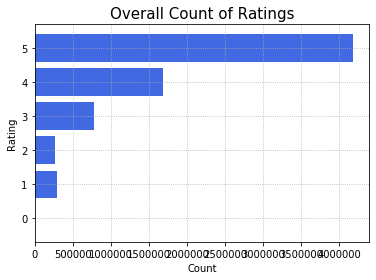

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [6]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [7]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [8]:
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [9]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
85246,叫醒耳朵????日语会话通(附MP3光盘2张),"832,1101,921",832,图书音像,1101,少儿/教育图书,921.0,外语
253148,轧制过程自动化,"832,1096,509",832,图书音像,1096,科技类图书,509.0,工业技术
253577,故事盒6:龟兔赛跑(1磁带),"911,819,1008",911,母婴/玩具,819,孕妇用品,1008.0,胎教/胎心仪
157598,季季乐 童装2013新款春秋装 男童长袖套头卫衣套头衫 儿童长袖外套BWQT1203(90c...,"802,777,914",802,服饰服装,777,童装/童鞋/亲子装,914.0,儿童上装
67652,日本语作文教室:基础篇,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试
371285,出口日本南部原单云作铸铁壶(富贵珠花纹)容量0.9升【黑色】H0901,"933,833,950",933,家居生活,833,厨房/餐具,950.0,锅具
268743,The Wildlife of Star Wars: A Field Guide,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
218502,俄罗斯经典绘画:希什金风景画选,"832,519,1076",832,图书音像,519,文学艺术,1076.0,艺术
436563,Red Dragon,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


,userId,productId,rating
2302072,7811.0,218635,4.0
2772666,22785.0,443787,3.0
4107939,3400.0,29738,1.0
4790905,35965.0,253302,5.0
4461816,4251.0,14103,5.0
6443992,24003.0,102968,3.0
6165199,39458.0,3944,5.0
2632459,50316.0,178056,2.0
2483540,39977.0,312207,5.0
4991047,270.0,347091,4.0


(35024, 3)

In [11]:
ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' , inplace =True )
ratingFilteredPivot = ratingFiltered.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

In [12]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)
print(ratingFiltered.iloc[0].userId)
print(ratingFiltered.loc[198])
print(ratingFiltered.index.get_loc(198))
display(ratingFilteredPivot.sample(10))
display(ratingFilteredPivot.iloc[0].name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island
56597.0
userId        56597.0
productId    452639.0
rating            3.0
Name: 198, dtype: float64
0


productId,4,11,24,31,47,54,115,119,176,180,...,525340,525356,525367,525377,525390,525414,525440,525469,525568,525607
userId,,,,,,,,,,,,,,,,,,,,,
73982.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7811.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12774.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85591.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107591.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


47.0

In [13]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [14]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
13669,213477,NBA历史500巨星,"832,552,840",832,图书音像,552,音像,840.0,专题片/专栏,953.0,3.0
10241,159185,战国策(套装上下册),"832,723,1052",832,图书音像,723,人文社科类图书,1052.0,古籍,63535.0,3.0
17730,277210,新航道?9分达人雅思阅读真题还原及解析2,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,47395.0,5.0
2462,35378,HARRYSON 哈迪森 男士 商务牛皮长款银包、卡片包 7415A-D206A,"518,261,592",518,鞋类箱包,261,功能箱包,592.0,卡套卡包,32773.0,4.0
33636,517751,自私的猪,"832,519,164",832,图书音像,519,文学艺术,164.0,动漫/幽默,5693.0,4.0
30990,478657,维罗妮卡决定去死,"832,519,1",832,图书音像,519,文学艺术,1.0,小说,1355.0,5.0
28160,436916,进口CD:云水吟(CD)SMCD-1009,"802,681,690",802,服饰服装,681,女装,690.0,民族/舞台服装,4624.0,5.0
415,6425,天堂伞三折自开自收超大晴雨伞 蓝色 3331E碰(一甩干)两种图案随机发放,"933,659,442",933,家居生活,659,生活日用,442.0,雨伞/阳伞/配件,6502.0,5.0
3306,48955,PHILIPS飞利浦HQ851/16两刀头充电式电动剃须刀,"222,621,691",222,家用电器,621,个人护理电器,691.0,电动剃须刀,270.0,5.0
2537,37297,Aesop's Fables,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,18235.0,3.0


In [15]:
ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' , inplace =True )
ratingFilteredPivot = ratingFiltered.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

In [16]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    similarities, indices=findksimilarusers(user_id, ratings,metric, k)
     #similar users based on cosine similarity
    mean_rating = ratings.loc[user_id-1,:].mean() 
     #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_id-1]
            -np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print '\nPredicted rating for user {0} -> item {1}: {2}'.
    format(user_id,item_id,prediction)

    return prediction

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('\nPredicted rating for user {0} -> item {1}: {2}'.)? (<ipython-input-16-54b4a7e27c6c>, line 21)

In [18]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
#user based:
raitingFilteredMatrix = csr_matrix(ratingFilteredPivot.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(raitingFilteredMatrix)
NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine', metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

#119->userId
#114416 , 3400 , 17750 ,83601 => 0.7
# 127020.0 => 0.3
# 127579.0 => 0.3
queryIndex = ratingFilteredPivot.index.get_loc(127020)
# queryIndex = np.random.choice(ratingFilteredPivot.shape[0])
distances, indices = model_knn.kneighbors(ratingFilteredPivot.iloc[queryIndex, :].values.reshape(1, -1), n_neighbors=6)

print('Recommendations for User({0}) :\n'.format( ratingFilteredPivot.iloc[queryIndex].name ))

for i in range(0, len(distances.flatten())):
      print('{0}: User({1}) , with distance of {2}:'.format(i, 
                                                            ratingFilteredPivot.iloc[indices.flatten()[i]].name,
                                                            distances.flatten()[i]))
        
prediction=0
similarities = 1-distances.flatten()
display(similarities)
mean_rating = ratingFilteredPivot.iloc[queryIndex, :].mean() 
# sum_wt = np.sum(similarities)-1
sum_wt = np.sum(similarities)
product=1
wtd_sum = 0 

# for i in range(0, len(indices.flatten())):
#     if i == 0:
#         pass;
#     else: 
#         ratings_diff = ratingFilteredPivot.iloc[indices.flatten()[i],item_id-1] 
#         - np.mean(ratings.iloc[indices.flatten()[i],:])
#         product = ratings_diff * (similarities[i])
#         wtd_sum = wtd_sum + product
# prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
# print '\nPredicted rating for user {0} -> item {1}: {2}'.
# format(user_id,item_id,prediction)

for i in range(0, len(indices.flatten())):
    if i == 0:
        pass;
    else: 
        ratings_diff = ratingFilteredPivot.iloc[indices.flatten()[i],item_id-1] 
        - np.mean(ratings.iloc[indices.flatten()[i],:])
        product = ratings_diff * (similarities[i])
        wtd_sum = wtd_sum + product
prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
print ('\nPredicted rating for user {0} -> item {1}: {2}'.
format(user_id,item_id,prediction))

Recommendations for User(127020.0) :

0: User(127020.0) , with distance of 0.0:
1: User(127579.0) , with distance of 0.32522736007593467:
2: User(6267.0) , with distance of 0.4229442986221119:
3: User(12195.0) , with distance of 0.5992337220460817:
4: User(48026.0) , with distance of 0.6128328059331198:
5: User(35965.0) , with distance of 0.6626272956018002:


array([1.        , 0.67477264, 0.5770557 , 0.40076628, 0.38716719,
       0.3373727 ])

NameError: name 'item_id' is not defined

In [ ]:
prediction=0
similarities = 1-distances.flatten()
sum_wt = np.sum(similarities)
wtd_sum = 0 

tempUserId = 7488
notRatedItems = np.setdiff1d(ratingFilteredPivot.columns.to_numpy() , ratingFilteredPivot[ (ratingFilteredPivot.index == tempUserId) ].iloc[0].nonzero()[0] )

predictionOfNotRateItems = []
for item in notRatedItems.tolist():
    weightedRatingSum = 0
    for i in range(0, len(indices.flatten())):
        ratingUserToItem = ratingFilteredPivot.loc[ratingFilteredPivot.iloc[indices.flatten()[i]].name,item] * similarities[i]
        weightedRatingSum += ratingUserToItem
    predictionOfNotRateItems.append(int(round( weightedRatingSum/sum_wt)))
    
predictionOfNotRateItems = np.array(predictionOfNotRateItems)
sortedIndex = predictionOfNotRateItems.argsort()[::-1][:10]


print(predictionOfNotRateItems)

for index , productId in enumerate(sortedIndex.tolist()):
    print('({0}). Prediction of User({1}):( {2} | {3} | {4} ):'.format(index,
                                                                       tempUserId,
                                                                       products.iloc[productId].cat1_name,
                                                                       products.iloc[productId].cat2_name,
                                                                       products.iloc[productId].cat3_name ))

In [120]:
# display(ratingFilteredPivot[ratingFilteredPivot.iloc[0].name == 127579.0 ])
# display(ratingFilteredPivot[ratingFilteredPivot.index ==  127579])
# display(ratingFilteredPivot[ratingFilteredPivot.index ==  127020])

display(ratingFiltered[ (ratingFiltered.userId == 6267)  ].head(50))

,userId,productId,rating
238310,6267.0,306453,5.0
524286,6267.0,45778,5.0
578877,6267.0,49616,4.0
587558,6267.0,364792,5.0
668800,6267.0,370499,5.0
807478,6267.0,379192,5.0
843684,6267.0,381668,4.0
951562,6267.0,111166,4.0
953508,6267.0,111239,4.0
954564,6267.0,111300,5.0


In [86]:
def findGood(userId):
    queryIndex = ratingFilteredPivot.index.get_loc(userId)
    # queryIndex = np.random.choice(ratingFilteredPivot.shape[0])
    distances, indices = model_knn.kneighbors(ratingFilteredPivot.iloc[queryIndex, :].values.reshape(1, -1), n_neighbors=6)
    if distances.flatten()[1] < 0.4:
        print(str(ratingFilteredPivot.iloc[queryIndex].name))
#     for i in range(0, len(distances.flatten())):
#           print('{0}: User({1}) , with distance of {2}:'.format(i, 
#                                                                 ratingFilteredPivot.iloc[indices.flatten()[i]].name,
#                                                                 distances.flatten()[i]))   

In [88]:
# display(ratingFilteredPivot.index[0])
# display(ratingFilteredPivot.head())
# print(type(ratingFilteredPivot.index.values.tolist()))
for i in ratingFilteredPivot.index.values.tolist():
    findGood(i)

127020.0
127579.0


In [32]:
display(ratingFilteredPivot.loc[127020])

productId
4         0.0
11        0.0
24        0.0
31        0.0
47        0.0
54        0.0
115       0.0
119       0.0
176       0.0
180       0.0
226       0.0
240       0.0
270       0.0
273       0.0
280       0.0
322       0.0
360       0.0
391       0.0
421       0.0
442       0.0
510       0.0
575       0.0
606       0.0
615       0.0
641       0.0
657       0.0
684       0.0
693       0.0
698       0.0
748       0.0
         ... 
524903    0.0
524921    0.0
524945    0.0
525002    0.0
525044    0.0
525071    0.0
525094    0.0
525101    0.0
525135    0.0
525140    0.0
525151    0.0
525171    0.0
525174    0.0
525187    0.0
525193    0.0
525196    0.0
525197    0.0
525216    0.0
525303    0.0
525339    0.0
525340    0.0
525356    0.0
525367    0.0
525377    0.0
525390    0.0
525414    0.0
525440    0.0
525469    0.0
525568    0.0
525607    0.0
Name: 127020.0, Length: 22683, dtype: float64

In [41]:
display(ratingFilteredPivot.loc[2097,4])

0.0